In [28]:
#import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import os
from scipy.signal import find_peaks, medfilt, butter, sosfilt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,roc_curve, roc_auc_score, classification_report, f1_score, precision_score, recall_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import he_normal



In [4]:
#opening the csv file that contains the data information 
data=pd.read_csv(r"C:\Users\shada\Desktop\project trying my best part 2\data\ptbxl_database.csv") #add path to csv file
data.head()

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


In [5]:
#geting the path of each record present in the csv file and save it in 'filename_lr' column 
filename=data['filename_lr']
data['filename_hr'] = [os.path.join("C:\\Users\\shada\\Desktop\\project trying my best part 2\\data\\", filename)
                       for filename in data['filename_lr']]
print(data['filename_hr'])
data.head()

0        C:\Users\shada\Desktop\project trying my best ...
1        C:\Users\shada\Desktop\project trying my best ...
2        C:\Users\shada\Desktop\project trying my best ...
3        C:\Users\shada\Desktop\project trying my best ...
4        C:\Users\shada\Desktop\project trying my best ...
                               ...                        
21794    C:\Users\shada\Desktop\project trying my best ...
21795    C:\Users\shada\Desktop\project trying my best ...
21796    C:\Users\shada\Desktop\project trying my best ...
21797    C:\Users\shada\Desktop\project trying my best ...
21798    C:\Users\shada\Desktop\project trying my best ...
Name: filename_hr, Length: 21799, dtype: object


,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,C:\Users\shada\Desktop\project trying my best ...
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,C:\Users\shada\Desktop\project trying my best ...
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,C:\Users\shada\Desktop\project trying my best ...
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,C:\Users\shada\Desktop\project trying my best ...
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,C:\Users\shada\Desktop\project trying my best ...


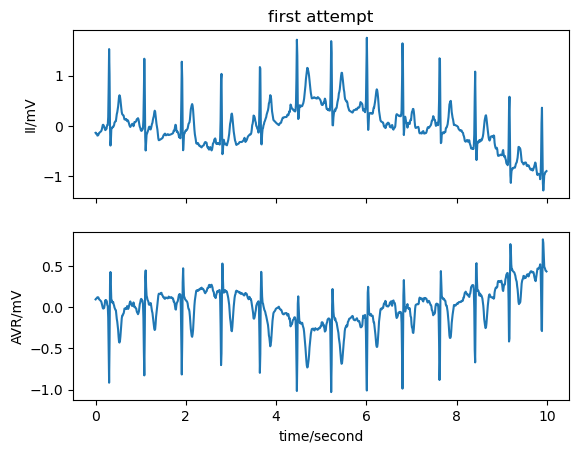

{'record_name': '00004_lr',
 'n_sig': 2,
 'fs': 100,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 1000,
 'base_time': None,
 'base_date': None,
 'comments': [],
 'sig_name': ['II', 'AVR'],
 'p_signal': array([[-0.138,  0.096],
        [-0.156,  0.105],
        [-0.153,  0.108],
        ...,
        [-0.915,  0.445],
        [-0.91 ,  0.442],
        [-0.899,  0.436]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['00004_lr.dat', '00004_lr.dat'],
 'fmt': ['16', '16'],
 'samps_per_frame': [1, 1],
 'skew': [None, None],
 'byte_offset': [None, None],
 'adc_gain': [1000.0, 1000.0],
 'baseline': [0, 0],
 'units': ['mV', 'mV'],
 'adc_res': [16, 16],
 'adc_zero': [0, 0],
 'init_value': [-138, 96],
 'checksum': [3502, 65415],
 'block_size': [0, 0]}

In [6]:
#trying a separate record 
b=r"C:\Users\shada\Desktop\project trying my best part 2\data\records100\00000\00004_lr"
record = wfdb.rdrecord(b,sampfrom = 0,sampto=1000
                       ,channels=[1,3]) 
wfdb.plot_wfdb(record=record, title='first attempt') 
display(record.__dict__)

In [ ]:
# itrating over each record a plot it
for i in data['filename_hr']:
    record = wfdb.rdrecord(i,sampfrom = 100,sampto=200 ,channels=[0,1])
    wfdb.plot_wfdb(record=record, title='first attempt') 


In [8]:
#making a separate DataFrame that contains specific columns "desired columns"

desired_columns = ['patient_id', 'scp_codes', 'filename_hr','baseline_drift','static_noise','burst_noise','electrodes_problems','extra_beats']  # Replace these with the actual column names you want
separate_data = data[desired_columns].copy()
df = pd.DataFrame(separate_data)

#making a function to extract first key of the 'scp_codes' column as it contains the diagnose 
def extract_first_key(scp_codes):
    scp_dict = eval(scp_codes)
    first_key = next(iter(scp_dict.keys()), None)
    return first_key

# Apply function to create new column with first key
df['scp_codes'] = df['scp_codes'].apply(extract_first_key)

print(df)


       patient_id scp_codes  \
0         15709.0      NORM   
1         13243.0      NORM   
2         20372.0      NORM   
3         17014.0      NORM   
4         17448.0      NORM   
...           ...       ...   
21794     17180.0       NDT   
21795     20703.0      NORM   
21796     19311.0     ISCAS   
21797      8873.0      NORM   
21798     11744.0      NORM   

                                             filename_hr  baseline_drift  \
0      C:\Users\shada\Desktop\project trying my best ...             NaN   
1      C:\Users\shada\Desktop\project trying my best ...             NaN   
2      C:\Users\shada\Desktop\project trying my best ...             NaN   
3      C:\Users\shada\Desktop\project trying my best ...    , II,III,AVF   
4      C:\Users\shada\Desktop\project trying my best ...   , III,AVR,AVF   
...                                                  ...             ...   
21794  C:\Users\shada\Desktop\project trying my best ...             NaN   
21795  C:\Users\sha

In [10]:
# as we only make a binary classification with 'IMI' disease we group by the classes and then take equal parts of 'IMI' and 'NORM' so we could have balanced data
grouped = df.groupby(df['scp_codes'])
X_data = []
for scp_codes in ['NORM', 'IMI']:
    X_data.append(grouped.get_group(scp_codes).sample(n=2317)) 
result = pd.concat(X_data) 
print(result)
print(len(result))


       patient_id scp_codes  \
20942     17333.0      NORM   
7524      18610.0      NORM   
20363     17065.0      NORM   
2313      12073.0      NORM   
8976       1059.0      NORM   
...           ...       ...   
9795      13457.0       IMI   
11143     19786.0       IMI   
9219      13093.0       IMI   
15421     14463.0       IMI   
421        5393.0       IMI   

                                             filename_hr baseline_drift  \
20942  C:\Users\shada\Desktop\project trying my best ...            NaN   
7524   C:\Users\shada\Desktop\project trying my best ...            NaN   
20363  C:\Users\shada\Desktop\project trying my best ...            NaN   
2313   C:\Users\shada\Desktop\project trying my best ...            NaN   
8976   C:\Users\shada\Desktop\project trying my best ...            NaN   
...                                                  ...            ...   
9795   C:\Users\shada\Desktop\project trying my best ...           , V3   
11143  C:\Users\shada\Deskt

In [13]:
#the data contain electrode problems and i want toremove them as they are so small persentage
print(result['electrodes_problems'].value_counts()) 

# Define the condition to filter rows based on the 'electrodes_problems' column
condition = ~result['electrodes_problems'].isin(['V5', 'V1', 'V3','v6????','aVL???','V5,V6','V6'])

# Filter rows based on the condition
result_filtered = result[condition]

print(result_filtered.count())

electrodes_problems
v6????    1
V5,V6     1
aVL???    1
V1        1
V3        1
Name: count, dtype: int64
patient_id             4629
scp_codes              4629
filename_hr            4629
baseline_drift          303
static_noise            737
burst_noise             136
electrodes_problems       0
extra_beats             409
dtype: int64


In [21]:
# encode the target value so it can be processed using CNN model
label_map = {'IMI': 0, 'NORM': 1}

# Applying the map function to the 'scp_codes' column
result_filtered['scp_codes'] = result_filtered['scp_codes'].map(label_map)

# Printing the modified DataFrame
print(result_filtered)

       patient_id  scp_codes  \
20942     17333.0          1   
7524      18610.0          1   
20363     17065.0          1   
2313      12073.0          1   
8976       1059.0          1   
...           ...        ...   
9795      13457.0          0   
11143     19786.0          0   
9219      13093.0          0   
15421     14463.0          0   
421        5393.0          0   

                                             filename_hr baseline_drift  \
20942  C:\Users\shada\Desktop\project trying my best ...            NaN   
7524   C:\Users\shada\Desktop\project trying my best ...            NaN   
20363  C:\Users\shada\Desktop\project trying my best ...            NaN   
2313   C:\Users\shada\Desktop\project trying my best ...            NaN   
8976   C:\Users\shada\Desktop\project trying my best ...            NaN   
...                                                  ...            ...   
9795   C:\Users\shada\Desktop\project trying my best ...           , V3   
11143  C:\Users

C:\Users\shada\AppData\Local\Temp\ipykernel_8292\587958758.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_filtered['scp_codes'] = result_filtered['scp_codes'].map(label_map)


In [16]:
# normalization, r_peak detection, filters applying, beat spliting and saving functions 
def detect_r_peaks(ecg_signal):
    r_peaks, _ = find_peaks(ecg_signal, height=0, distance=50)
    return r_peaks

def segment_beats(ecg_signal, r_peaks, max_length):
    beats = []
    for i in range(len(r_peaks) - 1):
        beat_start = r_peaks[i]
        beat_end = r_peaks[i + 1]
        beat = ecg_signal[beat_start:beat_end]
        if len(beat) > max_length:
            beat = beat[:max_length]
        elif len(beat) < max_length:
            beat = np.pad(beat, (0, max_length - len(beat)), 'constant')
        beats.append(beat)
    return beats

def z_score_normalize(signal):
    mean = np.mean(signal)
    std = np.std(signal)
    normalized_signal = (signal - mean) / std
    return normalized_signal

def process_ecg_record(record_path, max_length):
    record = wfdb.rdrecord(record_path)
    num_leads = record.p_signal.shape[1]
    
    # Use the first lead as the reference lead to detect R-peaks
    lead_signal_ref = record.p_signal[:, 0]

    # Apply median filter
    filtered_signal_median_ref = medfilt(lead_signal_ref, kernel_size=3)

    # Apply high-pass filter to correct baseline drift
    sos_ref = butter(4, 0.5, 'highpass', fs=record.fs, output='sos')
    filtered_signal_ref = sosfilt(sos_ref, filtered_signal_median_ref)

    # Apply Z-score normalization
    normalized_signal_ref = z_score_normalize(filtered_signal_ref)

    # Detect R-peaks on the normalized signal of the reference lead
    r_peaks_indices = detect_r_peaks(normalized_signal_ref)

    all_beats = [[] for _ in range(num_leads)]

    for i in range(num_leads):
        lead_signal = record.p_signal[:, i]

        # Apply median filter
        filtered_signal_median = medfilt(lead_signal, kernel_size=3)

        # Apply high-pass filter to correct baseline drift
        sos = butter(4, 0.5, 'highpass', fs=record.fs, output='sos')
        filtered_signal = sosfilt(sos, filtered_signal_median)

        # Apply Z-score normalization
        normalized_signal = z_score_normalize(filtered_signal)

        # Segment the ECG signal into beats using the R-peaks from the reference lead
        beats = segment_beats(normalized_signal, r_peaks_indices, max_length)

        all_beats[i].extend(beats)

    # Combine beats from all leads into a single array with shape (num_beats, max_length, num_leads)
    num_beats = len(all_beats[0])
    combined_beats = np.zeros((num_beats, max_length, num_leads), dtype=np.float32)
    for i in range(num_leads):
        combined_beats[:, :, i] = all_beats[i][:num_beats]

    return combined_beats
#a code to itrate over each record and applying the above functions then saving them in array
def process_ecg_records_from_dataframe(dataframe, max_length):
    all_records = []
    all_labels = []
    for idx, row in dataframe.iterrows():
        record_path = row['filename_hr']
        label = row['scp_codes']  # Assuming 'scp_codes' is the label column
        print(f"Processing record: {record_path}")
        all_records.append(process_ecg_record(record_path, max_length))
        all_labels.append(label)
    return all_records, all_labels
# creat a dataset to make it easier to split into train, validation and test
def create_dataset(ecg_records, labels):
    X = []
    y = []
    for record, label in zip(ecg_records, labels):
        X.extend(record)  # No need to stack, since each beat is already processed
        y.extend([label] * record.shape[0])  # Assign the label to each beat
    X = np.array(X)
    y = np.array(y)
    return X, y



In [22]:
#applying all the above functions 
df = result_filtered  
# Define the maximum length for beats
max_length = 500

# Split the DataFrame into train(70%), validation(15%), and test(15%) sets
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Process all ECG records listed in each subset
print("Processing Training Set")
train_records, train_labels = process_ecg_records_from_dataframe(train_df, max_length)

print("Processing Validation Set")
val_records, val_labels = process_ecg_records_from_dataframe(val_df, max_length)

print("Processing Test Set")
test_records, test_labels = process_ecg_records_from_dataframe(test_df, max_length)

# Create datasets for training, validation, and testing
X_train, y_train = create_dataset(train_records, train_labels)
X_val, y_val = create_dataset(val_records, val_labels)
X_test, y_test = create_dataset(test_records, test_labels)

# Reshape the data to fit the CNN input shape
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")


Processing Training Set
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/07000/07130_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/00000/00246_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/13000/13810_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/16000/16140_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/00000/00288_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/16000/16643_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/18000/18180_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/00000/00280_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/15000/15363_lr
Processing record: C:\Users\shada\Desktop\project

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/17000/17263_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/17000/17817_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/08000/08655_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/12000/12180_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/09000/09218_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/07000/07313_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/04000/04509_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/14000/14884_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/16000/16057_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/13000/13532_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/18000/18404_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/07000/07482_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/13000/13912_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/08000/08507_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/11000/11106_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/06000/06527_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/07000/07710_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/14000/14359_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/14000/14208_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/18000/18907_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/06000/06845_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/20000/20921_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/07000/07009_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/00000/00262_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/01000/01127_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/18000/18168_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/15000/15618_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/17000/17085_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/09000/09244_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/03000/03372_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/15000/15381_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/02000/02884_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/12000/12365_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/03000/03127_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/15000/15487_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/00000/00033_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/18000/18878_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/02000/02848_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/16000/16618_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/02000/02277_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/08000/08420_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/18000/18383_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/17000/17422_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/10000/10423_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/00000/00531_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/03000/03876_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/21000/21421_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/20000/20483_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/16000/16595_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/17000/17474_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/18000/18513_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/09000/09145_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/10000/10628_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/16000/16493_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/08000/08814_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/16000/16123_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/07000/07634_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/16000/16471_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/01000/01438_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/15000/15375_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/07000/07208_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/05000/05761_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/03000/03473_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/12000/12069_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/14000/14977_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/09000/09744_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/05000/05009_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/05000/05819_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/12000/12499_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/09000/09510_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/18000/18415_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/01000/01282_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/12000/12455_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/07000/07425_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/07000/07966_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/03000/03964_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/05000/05351_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/01000/01079_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/01000/01664_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/04000/04232_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/04000/04221_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/02000/02660_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/12000/12033_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/06000/06903_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/08000/08024_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/11000/11243_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/12000/12059_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/13000/13245_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/07000/07175_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/20000/20137_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/16000/16233_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/12000/12815_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/01000/01998_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/03000/03351_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/16000/16791_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/08000/08161_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/15000/15179_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/13000/13905_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/06000/06843_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/06000/06292_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/08000/08512_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/15000/15186_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/21000/21624_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/00000/00654_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/11000/11570_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/02000/02308_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/03000/03721_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/10000/10202_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/10000/10242_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/09000/09382_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/17000/17420_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/08000/08597_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/07000/07364_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/15000/15611_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/07000/07641_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/12000/12698_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/16000/16891_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/00000/00159_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/05000/05669_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/06000/06814_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/10000/10414_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/21000/21140_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/10000/10091_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/08000/08961_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/12000/12925_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/10000/10121_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/21000/21477_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/14000/14861_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/07000/07263_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/06000/06667_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/00000/00700_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/15000/15809_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/09000/09483_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/19000/19796_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/19000/19264_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/15000/15506_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/17000/17524_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/20000/20046_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/06000/06006_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/13000/13502_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/08000/08761_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/01000/01209_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/06000/06059_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/05000/05633_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/16000/16000_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/21000/21452_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/04000/04210_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/02000/02098_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/10000/10210_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/08000/08909_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/12000/12715_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/05000/05017_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/07000/07747_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/06000/06690_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/10000/10737_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/21000/21077_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/02000/02249_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/18000/18270_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/00000/00663_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/20000/20193_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/13000/13297_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/07000/07877_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/01000/01224_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/14000/14627_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/20000/20123_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/04000/04209_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/18000/18853_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/03000/03923_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/18000/18704_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/06000/06546_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/11000/11406_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/11000/11829_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/19000/19612_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/18000/18832_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/07000/07311_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/14000/14318_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/05000/05493_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/15000/15546_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/21000/21156_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/15000/15698_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/06000/06043_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/01000/01900_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/19000/19768_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/15000/15510_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/13000/13835_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/02000/02591_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/00000/00196_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/17000/17156_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/21000/21403_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/02000/02987_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/07000/07703_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/17000/17107_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/05000/05146_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/11000/11631_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/08000/08120_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/11000/11382_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/08000/08789_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/06000/06280_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/18000/18291_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/19000/19014_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/20000/20115_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/19000/19145_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/06000/06016_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/10000/10166_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/18000/18988_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/09000/09881_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/20000/20779_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/05000/05831_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/17000/17612_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/13000/13819_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/03000/03587_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/11000/11973_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/06000/06152_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/17000/17393_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/07000/07435_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/00000/00374_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/11000/11784_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/08000/08151_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/00000/00913_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/21000/21536_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/03000/03899_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/19000/19504_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/03000/03579_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/17000/17409_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/09000/09725_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/21000/21655_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/18000/18113_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/20000/20862_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/20000/20533_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/03000/03883_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/14000/14321_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/00000/00335_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/17000/17865_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/14000/14886_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/13000/13616_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/13000/13669_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/01000/01706_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/14000/14765_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/07000/07744_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/08000/08499_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/13000/13213_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/08000/08033_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/09000/09252_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/14000/14293_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/01000/01366_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/00000/00025_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/08000/08402_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/03000/03684_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/19000/19910_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/02000/02045_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/11000/11734_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/03000/03482_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/20000/20003_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/00000/00803_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/15000/15143_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/11000/11653_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/16000/16035_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/12000/12754_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/13000/13598_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/21000/21161_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/12000/12217_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/06000/06528_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/10000/10311_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/08000/08130_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/18000/18526_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/07000/07008_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/13000/13021_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/16000/16846_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/12000/12130_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/12000/12873_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/14000/14705_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/17000/17913_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/19000/19467_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/13000/13902_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/11000/11392_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/03000/03866_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/03000/03734_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/05000/05553_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/19000/19177_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/21000/21226_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/14000/14530_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/16000/16072_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/06000/06197_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/01000/01673_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/07000/07146_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/09000/09903_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/17000/17794_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/13000/13373_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/03000/03983_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/00000/00221_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/18000/18947_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/04000/04869_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/12000/12617_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/06000/06139_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/10000/10441_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/04000/04213_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/00000/00804_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/02000/02606_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/19000/19572_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/00000/00554_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/20000/20627_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/07000/07594_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/05000/05317_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/17000/17808_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/17000/17075_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/19000/19364_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/12000/12405_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/03000/03536_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/20000/20091_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/12000/12124_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/12000/12529_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/08000/08301_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/04000/04351_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/06000/06467_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/03000/03159_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/03000/03069_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/02000/02523_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/10000/10744_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/14000/14018_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/04000/04992_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/07000/07000_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/20000/20954_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/00000/00250_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/14000/14253_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/11000/11285_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/16000/16524_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/17000/17921_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/08000/08947_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/20000/20184_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/02000/02078_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/03000/03460_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/17000/17709_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/03000/03275_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/05000/05055_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/10000/10880_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/17000/17879_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/15000/15733_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/02000/02100_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/21000/21476_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/04000/04252_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/04000/04554_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/00000/00904_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/09000/09886_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/10000/10157_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/11000/11605_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/12000/12378_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/02000/02607_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/04000/04188_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/01000/01373_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/19000/19103_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/17000/17439_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/20000/20337_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/17000/17574_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/07000/07126_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/01000/01292_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/12000/12625_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/15000/15699_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/17000/17518_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/03000/03179_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/17000/17224_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/00000/00241_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/11000/11678_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/01000/01177_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/02000/02824_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/06000/06288_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/15000/15563_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/17000/17932_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/05000/05428_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/13000/13073_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/00000/00628_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/21000/21653_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/00000/00429_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/04000/04562_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/06000/06892_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/13000/13496_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/19000/19363_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/11000/11726_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/16000/16898_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/06000/06980_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/07000/07478_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/15000/15734_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/12000/12934_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/09000/09826_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/08000/08547_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/07000/07460_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/00000/00163_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/03000/03667_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/02000/02137_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/04000/04831_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/06000/06357_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/10000/10585_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/06000/06520_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/04000/04890_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/15000/15080_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/11000/11142_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/09000/09487_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/17000/17318_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/10000/10457_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/14000/14640_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/16000/16010_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/20000/20414_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/00000/00325_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/17000/17737_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/04000/04705_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/02000/02227_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/00000/00824_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/11000/11443_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/00000/00989_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/01000/01762_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/20000/20016_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/13000/13631_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/05000/05255_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/21000/21726_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/11000/11905_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/13000/13888_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/01000/01978_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/02000/02091_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/07000/07535_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/21000/21257_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/11000/11301_lr
Processing Test Set
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/06000/06716_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/03000/03618_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/15000/15705_lr
Processing record: C:\Users\shada\Desktop\project try

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/19000/19649_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/04000/04309_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/00000/00122_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/02000/02363_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/20000/20778_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/02000/02399_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/20000/20119_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/15000/15197_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/15000/15479_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/21000/21159_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/06000/06674_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/00000/00269_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/03000/03760_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/07000/07164_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/09000/09282_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/04000/04287_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/01000/01290_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/21000/21320_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/17000/17813_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/00000/00604_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/00000/00540_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/17000/17491_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/01000/01454_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/15000/15285_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/04000/04422_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/16000/16918_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/17000/17446_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/05000/05219_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/05000/05163_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/10000/10940_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/15000/15331_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/14000/14908_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/04000/04879_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/05000/05202_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/11000/11151_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/18000/18494_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/16000/16225_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/13000/13943_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/08000/08350_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/07000/07959_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/05000/05256_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/11000/11522_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/04000/04164_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/20000/20964_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/21000/21512_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/13000/13564_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/09000/09972_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/09000/09505_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/09000/09243_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/18000/18015_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/20000/20379_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/17000/17456_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/17000/17545_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/15000/15496_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/13000/13353_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/05000/05509_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/16000/16967_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/19000/19589_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/10000/10865_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/15000/15970_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/20000/20173_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/08000/08726_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/08000/08413_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/16000/16895_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/12000/12488_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/20000/20920_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/03000/03237_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/11000/11686_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/12000/12356_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/18000/18388_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/05000/05506_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\data\records100/05000/05061_lr
Processing record: C:\Users\shada\Desktop\project trying my best part 2\d

In [23]:
print(y_train)

[0 0 0 ... 1 1 1]


In [24]:

num_classes=1 # binary classification 
# Define the CNN model
model = Sequential([
    Conv1D(filters=32, kernel_size=3, input_shape=(500, 12),kernel_initializer=he_normal()),
    LeakyReLU(alpha=0.01), 
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3),
    LeakyReLU(alpha=0.01),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3),
    LeakyReLU(alpha=0.01),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=256, kernel_size=3),
    LeakyReLU(alpha=0.01),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=512, kernel_size=3),
    LeakyReLU(alpha=0.01),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128),
    LeakyReLU(alpha=0.01),
    Dropout(0.5),
    Dense(num_classes, activation='sigmoid')  # Binary classification
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 498, 32)           1184      
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 498, 32)           0         
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 249, 32)           0         
 ng1D)                                                           
                                                                 
 conv1d_11 (Conv1D)          (None, 247, 64)           6208      
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 247, 64)           0         
                                                                 
 max_pooling1d_11 (MaxPooli  (None, 123, 64)           0         
 ng1D)                                                

In [25]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define the callbacks
callbacks = [
    ModelCheckpoint('best_model.h4', monitor='val_loss', save_best_only=True, mode='min', verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)
]


In [26]:

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_val, y_val),
                    callbacks=callbacks)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/20
305/305 [==============================] - ETA: 0s - loss: 0.3636 - accuracy: 0.8404
Epoch 1: val_loss improved from inf to 0.30760, saving model to best_model.h4
INFO:tensorflow:Assets written to: best_model.h4\assets


INFO:tensorflow:Assets written to: best_model.h4\assets


305/305 [==============================] - 176s 564ms/step - loss: 0.3636 - accuracy: 0.8404 - val_loss: 0.3076 - val_accuracy: 0.8699
Epoch 2/20
305/305 [==============================] - ETA: 0s - loss: 0.2583 - accuracy: 0.8928
Epoch 2: val_loss improved from 0.30760 to 0.28008, saving model to best_model.h4
INFO:tensorflow:Assets written to: best_model.h4\assets


INFO:tensorflow:Assets written to: best_model.h4\assets


305/305 [==============================] - 171s 561ms/step - loss: 0.2583 - accuracy: 0.8928 - val_loss: 0.2801 - val_accuracy: 0.8817
Epoch 3/20
305/305 [==============================] - ETA: 0s - loss: 0.2288 - accuracy: 0.9043
Epoch 3: val_loss improved from 0.28008 to 0.27155, saving model to best_model.h4
INFO:tensorflow:Assets written to: best_model.h4\assets


INFO:tensorflow:Assets written to: best_model.h4\assets


305/305 [==============================] - 170s 558ms/step - loss: 0.2288 - accuracy: 0.9043 - val_loss: 0.2716 - val_accuracy: 0.8853
Epoch 4/20
305/305 [==============================] - ETA: 0s - loss: 0.2071 - accuracy: 0.9142
Epoch 4: val_loss improved from 0.27155 to 0.26493, saving model to best_model.h4
INFO:tensorflow:Assets written to: best_model.h4\assets


INFO:tensorflow:Assets written to: best_model.h4\assets


305/305 [==============================] - 183s 601ms/step - loss: 0.2071 - accuracy: 0.9142 - val_loss: 0.2649 - val_accuracy: 0.8897
Epoch 5/20
305/305 [==============================] - ETA: 0s - loss: 0.1888 - accuracy: 0.9229
Epoch 5: val_loss did not improve from 0.26493
305/305 [==============================] - 169s 554ms/step - loss: 0.1888 - accuracy: 0.9229 - val_loss: 0.2670 - val_accuracy: 0.8902
Epoch 6/20
305/305 [==============================] - ETA: 0s - loss: 0.1717 - accuracy: 0.9294
Epoch 6: val_loss improved from 0.26493 to 0.26394, saving model to best_model.h4
INFO:tensorflow:Assets written to: best_model.h4\assets


INFO:tensorflow:Assets written to: best_model.h4\assets


305/305 [==============================] - 173s 567ms/step - loss: 0.1717 - accuracy: 0.9294 - val_loss: 0.2639 - val_accuracy: 0.8888
Epoch 7/20
305/305 [==============================] - ETA: 0s - loss: 0.1577 - accuracy: 0.9366
Epoch 7: val_loss did not improve from 0.26394
305/305 [==============================] - 169s 556ms/step - loss: 0.1577 - accuracy: 0.9366 - val_loss: 0.2704 - val_accuracy: 0.8933
Epoch 8/20
305/305 [==============================] - ETA: 0s - loss: 0.1448 - accuracy: 0.9415
Epoch 8: val_loss did not improve from 0.26394
305/305 [==============================] - 170s 558ms/step - loss: 0.1448 - accuracy: 0.9415 - val_loss: 0.2718 - val_accuracy: 0.8919
Epoch 9/20
305/305 [==============================] - ETA: 0s - loss: 0.1345 - accuracy: 0.9460
Epoch 9: val_loss did not improve from 0.26394
305/305 [==============================] - 172s 565ms/step - loss: 0.1345 - accuracy: 0.9460 - val_loss: 0.2708 - val_accuracy: 0.8909
Epoch 10/20
305/305 [==========

264/264 [==============================] - 9s 33ms/step
Confusion Matrix:
[[4139  314]
 [ 623 3343]]
Sensitivity: 0.8429147755925366
Specificity: 0.9294857399505951
F1 Score: 0.8770825134461498
Precision: 0.9141372709871479
Recall: 0.8429147755925366


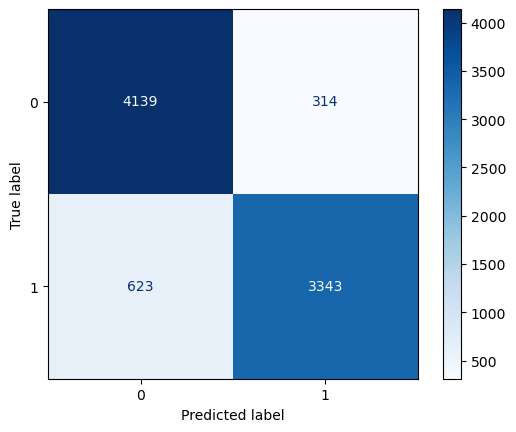

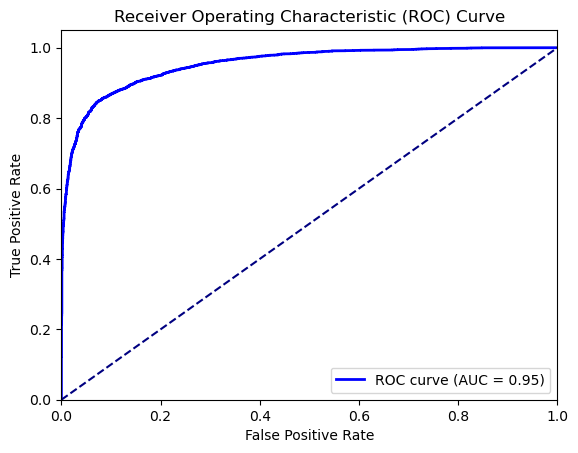

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      4453
           1       0.91      0.84      0.88      3966

    accuracy                           0.89      8419
   macro avg       0.89      0.89      0.89      8419
weighted avg       0.89      0.89      0.89      8419



In [29]:
# Predict the labels for the test set
y_pred_probs = model.predict(X_test)  # Probabilities for the positive class
y_pred_classes = (y_pred_probs > 0.5).astype("int32")  # Binary predicted class labels

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)


# Plot the confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap=plt.cm.Blues) 
print('Confusion Matrix:')
print(conf_matrix)

# Extracting true positives, false positives, true negatives, and false negatives
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate sensitivity (recall)
sensitivity = tp / (tp + fn)
print(f'Sensitivity: {sensitivity}')

# Calculate specificity
specificity = tn / (tn + fp)
print(f'Specificity: {specificity}')

# Calculate F1 score, precision, and recall
f1 = f1_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)

# Print the F1 score, precision, and recall
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
# ROC and AUC for binary classification
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = roc_auc_score(y_test, y_pred_probs)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred_classes))